fused-attention-batch4-head48-d64-fwd-causal=True:
     N_CTX     Triton
0   1024.0  17.303488
1   2048.0  22.396121
2   4096.0  24.372112
3   8192.0  24.106187
4  16384.0  24.376630
fused-attention-batch4-head48-d64-fwd-causal=False:
     N_CTX     Triton
0   1024.0  24.215882
1   2048.0  24.405237
2   4096.0  25.360837
3   8192.0  24.535958
4  16384.0  24.996997
fused-attention-batch4-head48-d64-bwd-causal=True:
     N_CTX     Triton
0   1024.0   9.997153
1   2048.0  12.630806
2   4096.0  14.507306
3   8192.0  15.387824
4  16384.0  16.218271


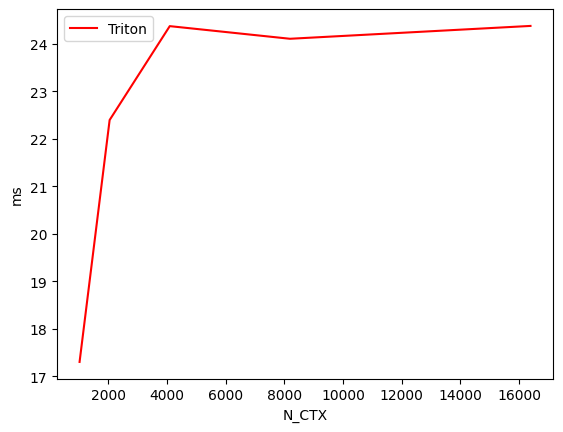

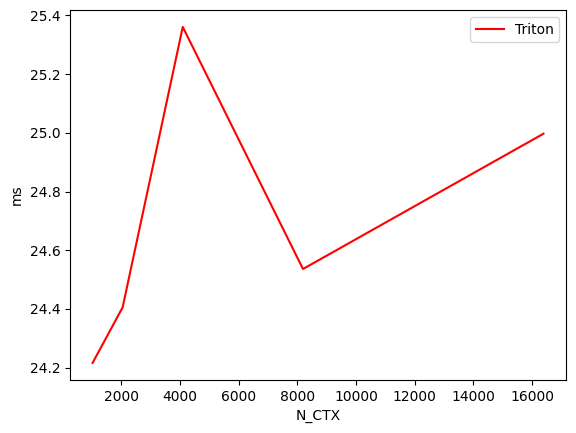

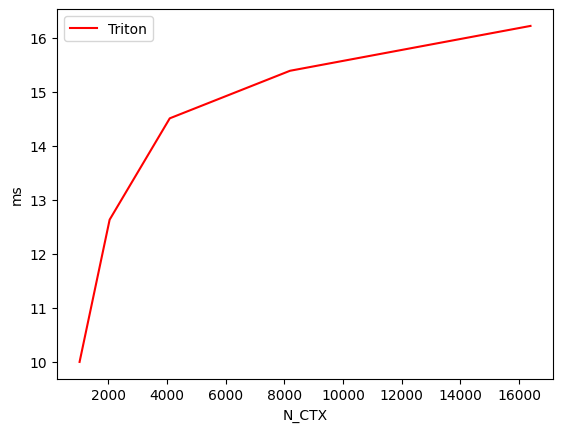

In [2]:
"""
Fused Attention
===============

This is a Triton implementation of the Flash Attention v2 algorithm from Tri Dao (https://tridao.me/publications/flash2/flash2.pdf)
Credits: OpenAI kernel team

Extra Credits:
- Original flash attention paper (https://arxiv.org/abs/2205.14135)
- Rabe and Staats (https://arxiv.org/pdf/2112.05682v2.pdf)

"""

import pytest
import torch

import triton
import triton.language as tl


@triton.jit
def _attn_fwd_inner(acc, l_i, m_i, q,  #
                    K_block_ptr, V_block_ptr,  #
                    start_m, qk_scale,  #
                    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr, BLOCK_N: tl.constexpr,  #
                    STAGE: tl.constexpr, offs_m: tl.constexpr, offs_n: tl.constexpr,  #
                    N_CTX: tl.constexpr):
    # range of values handled by this stage
    if STAGE == 1:
        lo, hi = 0, start_m * BLOCK_M
    elif STAGE == 2:
        lo, hi = start_m * BLOCK_M, (start_m + 1) * BLOCK_M
        lo = tl.multiple_of(lo, BLOCK_M)
    # causal = False
    else:
        lo, hi = 0, N_CTX
    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))
    # loop over k, v and update accumulator
    for start_n in range(lo, hi, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        # -- compute qk ----
        k = tl.load(K_block_ptr)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k)
        if STAGE == 2:
            mask = offs_m[:, None] >= (start_n + offs_n[None, :])
            qk = qk * qk_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(qk, 1))
            qk -= m_ij[:, None]
        else:
            m_ij = tl.maximum(m_i, tl.max(qk, 1) * qk_scale)
            qk = qk * qk_scale - m_ij[:, None]
        p = tl.math.exp2(qk)
        l_ij = tl.sum(p, 1)
        # -- update m_i and l_i
        alpha = tl.math.exp2(m_i - m_ij)
        l_i = l_i * alpha + l_ij
        # -- update output accumulator --
        acc = acc * alpha[:, None]
        # update acc
        v = tl.load(V_block_ptr)
        acc += tl.dot(p.to(tl.float16), v)
        # update m_i and l_i
        m_i = m_ij
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
    return acc, l_i, m_i


# We don't run auto-tuning everytime to keep the tutorial fast. Uncommenting
# the code below and commenting out the equivalent parameters is convenient for
# re-tuning.
# @triton.autotune(
#    configs=[
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=4, num_warps=8),
#        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
#        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 32}, num_stages=3, num_warps=8),
#        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 32}, num_stages=3, num_warps=4),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=3, num_warps=4),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=4, num_warps=4),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=3, num_warps=4),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=4, num_warps=4),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=7, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=7, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=6, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=5, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=4, num_warps=8),
#        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=6, num_warps=4),
#    ],
#    key=['N_CTX'],
# )


@triton.jit
def _attn_fwd(Q, K, V, sm_scale, M, Out,  #
              stride_qz, stride_qh, stride_qm, stride_qk,  #
              stride_kz, stride_kh, stride_kn, stride_kk,  #
              stride_vz, stride_vh, stride_vk, stride_vn,  #
              stride_oz, stride_oh, stride_om, stride_on,  #
              Z, H,  #
              N_CTX: tl.constexpr,  #
              BLOCK_M: tl.constexpr,  #
              BLOCK_DMODEL: tl.constexpr,  #
              BLOCK_N: tl.constexpr,  #
              STAGE: tl.constexpr  #
              ):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    off_z = off_hz // H
    off_h = off_hz % H
    qvk_offset = off_z.to(tl.int64) * stride_qz + off_h.to(tl.int64) * stride_qh

    # block pointers
    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, BLOCK_DMODEL),
        order=(1, 0),
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(BLOCK_DMODEL, N_CTX),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(BLOCK_DMODEL, BLOCK_N),
        order=(0, 1),
    )
    O_block_ptr = tl.make_block_ptr(
        base=Out + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    # initialize pointer to m and l
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    # load scales
    qk_scale = sm_scale
    qk_scale *= 1.44269504  # 1/log(2)
    # load q: it will stay in SRAM throughout
    q = tl.load(Q_block_ptr)
    # stage 1: off-band
    # For causal = True, STAGE = 3 and _attn_fwd_inner gets 1 as its STAGE
    # For causal = False, STAGE = 1, and _attn_fwd_inner gets 3 as its STAGE
    if STAGE & 1:
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,  #
                                        start_m, qk_scale,  #
                                        BLOCK_M, BLOCK_DMODEL, BLOCK_N,  #
                                        4 - STAGE, offs_m, offs_n, N_CTX  #
                                        )
    # stage 2: on-band
    if STAGE & 2:
        # barrier makes it easier for compielr to schedule the
        # two loops independently
        tl.debug_barrier()
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,  #
                                        start_m, qk_scale,  #
                                        BLOCK_M, BLOCK_DMODEL, BLOCK_N,  #
                                        2, offs_m, offs_n, N_CTX  #
                                        )
    # epilogue
    m_i += tl.math.log2(l_i)
    acc = acc / l_i[:, None]
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, acc.to(Out.type.element_ty))


@triton.jit
def _attn_bwd_preprocess(O, DO,  #
                         Delta,  #
                         Z, H, N_CTX,  #
                         BLOCK_M: tl.constexpr, D_HEAD: tl.constexpr  #
                         ):
    off_m = tl.program_id(0) * BLOCK_M + tl.arange(0, BLOCK_M)
    off_hz = tl.program_id(1)
    off_n = tl.arange(0, D_HEAD)
    # load
    o = tl.load(O + off_hz * D_HEAD * N_CTX + off_m[:, None] * D_HEAD + off_n[None, :])
    do = tl.load(DO + off_hz * D_HEAD * N_CTX + off_m[:, None] * D_HEAD + off_n[None, :]).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(Delta + off_hz * N_CTX + off_m, delta)


# The main inner-loop logic for computing dK and dV.
@triton.jit
def _attn_bwd_dkdv(dk, dv,  #
                   Q, k, v, sm_scale,  #
                   DO,  #
                   M, D,  #
                   # shared by Q/K/V/DO.
                   stride_tok, stride_d,  #
                   H, N_CTX, BLOCK_M1: tl.constexpr,  #
                   BLOCK_N1: tl.constexpr,  #
                   BLOCK_DMODEL: tl.constexpr,  #
                   # Filled in by the wrapper.
                   start_n, start_m, num_steps,  #
                   MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M1)
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    offs_k = tl.arange(0, BLOCK_DMODEL)
    qT_ptrs = Q + offs_m[None, :] * stride_tok + offs_k[:, None] * stride_d
    do_ptrs = DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    # BLOCK_N1 must be a multiple of BLOCK_M1, otherwise the code wouldn't work.
    tl.static_assert(BLOCK_N1 % BLOCK_M1 == 0)
    curr_m = start_m
    step_m = BLOCK_M1
    for blk_idx in range(num_steps):
        qT = tl.load(qT_ptrs)
        # Load m before computing qk to reduce pipeline stall.
        offs_m = curr_m + tl.arange(0, BLOCK_M1)
        m = tl.load(M + offs_m)
        qkT = tl.dot(k, qT)
        pT = tl.math.exp2(qkT - m[None, :])
        # Autoregressive masking.
        if MASK:
            mask = (offs_m[None, :] >= offs_n[:, None])
            pT = tl.where(mask, pT, 0.0)
        do = tl.load(do_ptrs)
        # Compute dV.
        ppT = pT
        ppT = ppT.to(tl.float16)
        dv += tl.dot(ppT, do)
        # D (= delta) is pre-divided by ds_scale.
        Di = tl.load(D + offs_m)
        # Compute dP and dS.
        dpT = tl.dot(v, tl.trans(do)).to(tl.float32)
        dsT = pT * (dpT - Di[None, :])
        dsT = dsT.to(tl.float16)
        dk += tl.dot(dsT, tl.trans(qT))
        # Increment pointers.
        curr_m += step_m
        qT_ptrs += step_m * stride_tok
        do_ptrs += step_m * stride_tok
    return dk, dv


# the main inner-loop logic for computing dQ
@triton.jit
def _attn_bwd_dq(dq, q, K, V,  #
                 do, m, D,
                 # shared by Q/K/V/DO.
                 stride_tok, stride_d,  #
                 H, N_CTX,  #
                 BLOCK_M2: tl.constexpr,  #
                 BLOCK_N2: tl.constexpr,  #
                 BLOCK_DMODEL: tl.constexpr,
                 # Filled in by the wrapper.
                 start_m, start_n, num_steps,  #
                 MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    offs_n = start_n + tl.arange(0, BLOCK_N2)
    offs_k = tl.arange(0, BLOCK_DMODEL)
    kT_ptrs = K + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    vT_ptrs = V + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    # D (= delta) is pre-divided by ds_scale.
    Di = tl.load(D + offs_m)
    # BLOCK_M2 must be a multiple of BLOCK_N2, otherwise the code wouldn't work.
    tl.static_assert(BLOCK_M2 % BLOCK_N2 == 0)
    curr_n = start_n
    step_n = BLOCK_N2
    for blk_idx in range(num_steps):
        kT = tl.load(kT_ptrs)
        vT = tl.load(vT_ptrs)
        qk = tl.dot(q, kT)
        p = tl.math.exp2(qk - m)
        # Autoregressive masking.
        if MASK:
            offs_n = curr_n + tl.arange(0, BLOCK_N2)
            mask = (offs_m[:, None] >= offs_n[None, :])
            p = tl.where(mask, p, 0.0)
        # Compute dP and dS.
        dp = tl.dot(do, vT).to(tl.float32)
        ds = p * (dp - Di[:, None])
        ds = ds.to(tl.float16)
        # Compute dQ.
        # NOTE: We need to de-scale dq in the end, because kT was pre-scaled.
        dq += tl.dot(ds, tl.trans(kT))
        # Increment pointers.
        curr_n += step_n
        kT_ptrs += step_n * stride_tok
        vT_ptrs += step_n * stride_tok
    return dq


@triton.jit
def _attn_bwd(Q, K, V, sm_scale,  #
              DO,  #
              DQ, DK, DV,  #
              M, D,
              # shared by Q/K/V/DO.
              stride_z, stride_h, stride_tok, stride_d,  #
              H, N_CTX,  #
              BLOCK_M1: tl.constexpr,  #
              BLOCK_N1: tl.constexpr,  #
              BLOCK_M2: tl.constexpr,  #
              BLOCK_N2: tl.constexpr,  #
              BLK_SLICE_FACTOR: tl.constexpr,  #
              BLOCK_DMODEL: tl.constexpr):
    LN2: tl.constexpr = 0.6931471824645996  # = ln(2)

    bhid = tl.program_id(2)
    off_chz = (bhid * N_CTX).to(tl.int64)
    adj = (stride_h * (bhid % H) + stride_z * (bhid // H)).to(tl.int64)
    pid = tl.program_id(0)

    # offset pointers for batch/head
    Q += adj
    K += adj
    V += adj
    DO += adj
    DQ += adj
    DK += adj
    DV += adj
    M += off_chz
    D += off_chz

    # load scales
    offs_k = tl.arange(0, BLOCK_DMODEL)

    start_n = pid * BLOCK_N1
    start_m = start_n

    MASK_BLOCK_M1: tl.constexpr = BLOCK_M1 // BLK_SLICE_FACTOR
    offs_n = start_n + tl.arange(0, BLOCK_N1)

    dv = tl.zeros([BLOCK_N1, BLOCK_DMODEL], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N1, BLOCK_DMODEL], dtype=tl.float32)

    # load K and V: they stay in SRAM throughout the inner loop.
    k = tl.load(K + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)
    v = tl.load(V + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)

    num_steps = BLOCK_N1 // MASK_BLOCK_M1

    dk, dv = _attn_bwd_dkdv(dk, dv,  #
                            Q, k, v, sm_scale,  #
                            DO,  #
                            M, D,  #
                            stride_tok, stride_d,  #
                            H, N_CTX,  #
                            MASK_BLOCK_M1, BLOCK_N1, BLOCK_DMODEL,  #
                            start_n, start_m, num_steps,  #
                            MASK=True  #
                            )

    start_m += num_steps * MASK_BLOCK_M1
    num_steps = (N_CTX - start_m) // BLOCK_M1

    # Compute dK and dV for non-masked blocks.
    dk, dv = _attn_bwd_dkdv(  #
        dk, dv,  #
        Q, k, v, sm_scale,  #
        DO,  #
        M, D,  #
        stride_tok, stride_d,  #
        H, N_CTX,  #
        BLOCK_M1, BLOCK_N1, BLOCK_DMODEL,  #
        start_n, start_m, num_steps,  #
        MASK=False  #
    )

    dv_ptrs = DV + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dv_ptrs, dv)

    # Write back dK.
    dk *= sm_scale
    dk_ptrs = DK + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dk_ptrs, dk)

    # THIS BLOCK DOES DQ:
    start_m = pid * BLOCK_M2
    end_n = start_m + BLOCK_M2

    MASK_BLOCK_N2: tl.constexpr = BLOCK_N2 // BLK_SLICE_FACTOR
    offs_m = start_m + tl.arange(0, BLOCK_M2)

    q = tl.load(Q + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    dq = tl.zeros([BLOCK_M2, BLOCK_DMODEL], dtype=tl.float32)
    do = tl.load(DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)

    m = tl.load(M + offs_m)
    m = m[:, None]

    # Compute dQ for masked (diagonal) blocks.
    # NOTE: This code scans each row of QK^T backward (from right to left,
    # but inside each call to _attn_bwd_dq, from left to right), but that's
    # not due to anything important.  I just wanted to reuse the loop
    # structure for dK & dV above as much as possible.
    num_steps = BLOCK_M2 // MASK_BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,  #
                      do, m, D,  #
                      stride_tok, stride_d,  #
                      H, N_CTX,  #
                      BLOCK_M2, MASK_BLOCK_N2, BLOCK_DMODEL,  #
                      start_m, end_n - num_steps * MASK_BLOCK_N2, num_steps,  #
                      MASK=True  #
                      )
    end_n -= num_steps * MASK_BLOCK_N2
    # stage 2
    num_steps = end_n // BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,  #
                      do, m, D,  #
                      stride_tok, stride_d,  #
                      H, N_CTX,  #
                      BLOCK_M2, BLOCK_N2, BLOCK_DMODEL,  #
                      start_m, end_n - num_steps * BLOCK_N2, num_steps,  #
                      MASK=False  #
                      )
    # Write back dQ.
    dq_ptrs = DQ + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    dq *= LN2
    tl.store(dq_ptrs, dq)


empty = torch.empty(128, device="cuda")


class _attention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, causal, sm_scale):
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        assert Lq == Lk and Lk == Lv
        assert Lk in {16, 32, 64, 128}
        o = torch.empty_like(q)
        BLOCK_M = 128
        BLOCK_N = 64 if Lk <= 64 else 32
        num_stages = 4 if Lk <= 64 else 3
        num_warps = 4
        stage = 3 if causal else 1
        # Tuning for H100
        if torch.cuda.get_device_capability()[0] == 9:
            num_warps = 8
            num_stages = 7 if Lk >= 64 else 3
        grid = (triton.cdiv(q.shape[2], BLOCK_M), q.shape[0] * q.shape[1], 1)
        M = torch.empty((q.shape[0], q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        _attn_fwd[grid](
            q, k, v, sm_scale, M, o,  #
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  #
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),  #
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),  #
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),  #
            q.shape[0], q.shape[1],  #
            N_CTX=q.shape[2],  #
            BLOCK_M=BLOCK_M,  #
            BLOCK_N=BLOCK_N,  #
            BLOCK_DMODEL=Lk,  #
            STAGE=stage,  #
            num_warps=num_warps,  #
            num_stages=num_stages  #
        )

        ctx.save_for_backward(q, k, v, o, M)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        ctx.causal = causal
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, M = ctx.saved_tensors
        assert do.is_contiguous()
        assert q.stride() == k.stride() == v.stride() == o.stride() == do.stride()
        dq = torch.empty_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        BATCH, N_HEAD, N_CTX = q.shape[:3]
        PRE_BLOCK = 128
        NUM_WARPS, NUM_STAGES = 4, 5
        BLOCK_M1, BLOCK_N1, BLOCK_M2, BLOCK_N2 = 32, 128, 128, 32
        BLK_SLICE_FACTOR = 2
        RCP_LN2 = 1.4426950408889634  # = 1.0 / ln(2)
        arg_k = k
        arg_k = arg_k * (ctx.sm_scale * RCP_LN2)
        PRE_BLOCK = 128
        assert N_CTX % PRE_BLOCK == 0
        pre_grid = (N_CTX // PRE_BLOCK, BATCH * N_HEAD)
        delta = torch.empty_like(M)
        _attn_bwd_preprocess[pre_grid](
            o, do,  #
            delta,  #
            BATCH, N_HEAD, N_CTX,  #
            BLOCK_M=PRE_BLOCK, D_HEAD=ctx.BLOCK_DMODEL  #
        )
        grid = (N_CTX // BLOCK_N1, 1, BATCH * N_HEAD)
        _attn_bwd[grid](
            q, arg_k, v, ctx.sm_scale, do, dq, dk, dv,  #
            M, delta,  #
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  #
            N_HEAD, N_CTX,  #
            BLOCK_M1=BLOCK_M1, BLOCK_N1=BLOCK_N1,  #
            BLOCK_M2=BLOCK_M2, BLOCK_N2=BLOCK_N2,  #
            BLK_SLICE_FACTOR=BLK_SLICE_FACTOR,  #
            BLOCK_DMODEL=ctx.BLOCK_DMODEL,  #
            num_warps=NUM_WARPS,  #
            num_stages=NUM_STAGES  #
        )

        return dq, dk, dv, None, None


attention = _attention.apply


@pytest.mark.parametrize("Z, H, N_CTX, D_HEAD", [(1, 2, 1024, 64)])
@pytest.mark.parametrize("causal", [True])
def test_op(Z, H, N_CTX, D_HEAD, causal, dtype=torch.float16):
    torch.manual_seed(20)
    q = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    k = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    v = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    sm_scale = 0.5
    dout = torch.randn_like(q)
    # reference implementation
    M = torch.tril(torch.ones((N_CTX, N_CTX), device="cuda"))
    p = torch.matmul(q, k.transpose(2, 3)) * sm_scale
    if causal:
        p[:, :, M == 0] = float("-inf")
    p = torch.softmax(p.float(), dim=-1).half()
    # p = torch.exp(p)
    ref_out = torch.matmul(p, v)
    ref_out.backward(dout)
    ref_dv, v.grad = v.grad.clone(), None
    ref_dk, k.grad = k.grad.clone(), None
    ref_dq, q.grad = q.grad.clone(), None
    # triton implementation
    tri_out = attention(q, k, v, causal, sm_scale).half()
    tri_out.backward(dout)
    tri_dv, v.grad = v.grad.clone(), None
    tri_dk, k.grad = k.grad.clone(), None
    tri_dq, q.grad = q.grad.clone(), None
    # compare
    assert torch.allclose(ref_out, tri_out, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dv, tri_dv, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dk, tri_dk, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dq, tri_dq, atol=1e-2, rtol=0)


try:
    from flash_attn.flash_attn_interface import \
        flash_attn_qkvpacked_func as flash_attn_func
    HAS_FLASH = True
except BaseException:
    HAS_FLASH = False

TORCH_HAS_FP8 = hasattr(torch, 'float8_e5m2')
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 48, 4096, 64
# vary seq length for fixed head and batch=4
configs = []
for mode in ["fwd", "bwd"]:
    for causal in [True, False]:
        if mode == "bwd" and not causal:
            continue
        configs.append(
            triton.testing.Benchmark(
                x_names=["N_CTX"],
                x_vals=[2**i for i in range(10, 15)],
                line_arg="provider",
                line_vals=["triton"] + (["flash"] if HAS_FLASH else []),
                line_names=["Triton"] + (["Flash-2"] if HAS_FLASH else []),
                styles=[("red", "-"), ("blue", "-")],
                ylabel="ms",
                plot_name=f"fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}-causal={causal}",
                args={
                    "H": N_HEADS,
                    "BATCH": BATCH,
                    "D_HEAD": D_HEAD,
                    "dtype": torch.float16,
                    "mode": mode,
                    "causal": causal,
                },
            ))


@triton.testing.perf_report(configs)
def bench_flash_attention(BATCH, H, N_CTX, D_HEAD, causal, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ["fwd", "bwd"]
    warmup = 25
    rep = 100
    if provider == "triton":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        if mode == "fwd" and TORCH_HAS_FP8:
            q = q.to(torch.float8_e5m2)
            k = k.to(torch.float8_e5m2)
        v = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        sm_scale = 1.3
        fn = lambda: attention(q, k, v, causal, sm_scale)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    if provider == "flash":
        qkv = torch.randn((BATCH, N_CTX, 3, H, D_HEAD), dtype=dtype, device=device, requires_grad=True)
        fn = lambda: flash_attn_func(qkv, causal=causal)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    flops_per_matmul = 2.0 * BATCH * H * N_CTX * N_CTX * D_HEAD
    total_flops = 2 * flops_per_matmul
    if causal:
        total_flops *= 0.5
    if mode == "bwd":
        total_flops *= 2.5  # 2.0(bwd) + 0.5(recompute)
    return total_flops / ms * 1e-9


# only works on post-Ampere GPUs right now
bench_flash_attention.run(save_path=".", print_data=True)
